In [1]:
import torch
from torch import nn
import torchvision
from torch.utils.data import Subset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cnn
import numpy as np
from datetime import datetime
import os 

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 1

transform_train = transforms.Compose([transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
     transforms.RandomAffine(degrees=0, translate =(0.1, 0.1)),
      transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

transform =  transforms.Compose([transforms.ToTensor(),
      transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

val_idx = [i for i in range(7000)]
test_idx = [i for i in range(10_000)]

valset = torch.utils.data.Subset(testset, val_idx)
testset = torch.utils.data.Subset(testset, test_idx)


valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


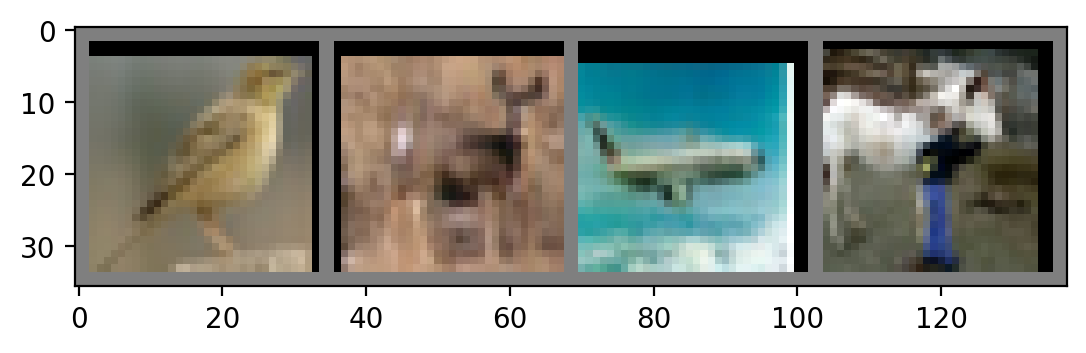

bird  deer  plane horse


In [3]:

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
for i in range(3):
    vgg = cnn.VGG(in_channels=3, batchnorm=False, dropout=False)
    vgg.to(device)
    criterion = nn.CrossEntropyLoss()
    lr = 1e-3
    epochs = 100
    momentum = 0.9
    optimizer = torch.optim.SGD(params=vgg.parameters(), momentum=momentum, lr=lr)
    trainer = cnn.Trainer(model=vgg, train_dataloader=trainloader, val_dataloader=valloader, criterion=criterion, optimizer=optimizer, device=device, log_dir="check_overfits_small_train/", obj_performance=0.84, early_stop_patience=5)

    path = 'models/vanilla_vgg_data_augmentation/lr_' + str(lr) + 'affine_01_random_hflip_' +  'bs_' + str(batch_size) + '_m_' + str(momentum) + '_n_epoch_' + str(epochs) + '_' + str(datetime.now()).replace(' ', '_').replace(':', '_').replace('.', '-')[:16]

    train_loss_list, train_acc_list, val_loss_list, val_acc_list = trainer.train(epochs=epochs)

    path += '_' + str(max(val_acc_list))[:5]
    model_path = path + '_model.pth'
    train_loss_path = path + '_train_loss.npy'
    val_loss_path = path + '_val_loss.npy'
    train_acc_path = path + '_train_acc.npy'
    val_acc_path = path + '_val_acc.npy'

    train_loss_list = np.array(train_loss_list)
    train_acc_list = np.array(train_acc_list)
    val_loss_list = np.array(val_loss_list)
    val_acc_list = np.array(val_acc_list)

    # Save all the model's output and the model

    torch.save(vgg, model_path)

    with open(train_loss_path, 'wb') as f:
        np.save(f, train_loss_list)

    with open(val_loss_path, 'wb') as f:
        np.save(f, val_loss_list)

    with open(train_acc_path, 'wb') as f:
        np.save(f, train_acc_list)

    with open(val_acc_path, 'wb') as f:
        np.save(f, val_acc_list)

VGG model with nothing


  1%|          | 1/100 [01:50<3:01:51, 110.22s/it]

Epoch 1/100: Train Loss = 2.3025, Train Accuracy = 0.1725, Val Loss = 2.3024, Val Accuracy = 0.2101


  2%|▏         | 2/100 [03:31<2:51:39, 105.10s/it]

Epoch 2/100: Train Loss = 2.2604, Train Accuracy = 0.1936, Val Loss = 2.1690, Val Accuracy = 0.2156


  3%|▎         | 3/100 [05:17<2:50:43, 105.60s/it]

Epoch 3/100: Train Loss = 2.0958, Train Accuracy = 0.2808, Val Loss = 2.0388, Val Accuracy = 0.3404


  4%|▍         | 4/100 [07:04<2:49:50, 106.15s/it]

Epoch 4/100: Train Loss = 2.0420, Train Accuracy = 0.3328, Val Loss = 2.0155, Val Accuracy = 0.3591


  4%|▍         | 4/100 [08:57<3:34:48, 134.25s/it]


Epoch 5/100: Train Loss = 2.0106, Train Accuracy = 0.3679, Val Loss = 1.9912, Val Accuracy = 0.3824
No improvement in validation accuracy for 5 epochs. Early stopping.
VGG model with nothing


  1%|          | 1/100 [01:42<2:49:19, 102.62s/it]

Epoch 1/100: Train Loss = 2.3026, Train Accuracy = 0.1394, Val Loss = 2.3025, Val Accuracy = 0.1691


  2%|▏         | 2/100 [03:30<2:53:04, 105.96s/it]

Epoch 2/100: Train Loss = 2.3008, Train Accuracy = 0.1761, Val Loss = 2.2292, Val Accuracy = 0.1816


  3%|▎         | 3/100 [05:14<2:49:24, 104.79s/it]

Epoch 3/100: Train Loss = 2.1539, Train Accuracy = 0.2266, Val Loss = 2.1382, Val Accuracy = 0.2456


In [ ]:
plt.plot(train_acc_list)
plt.plot(val_acc_list)

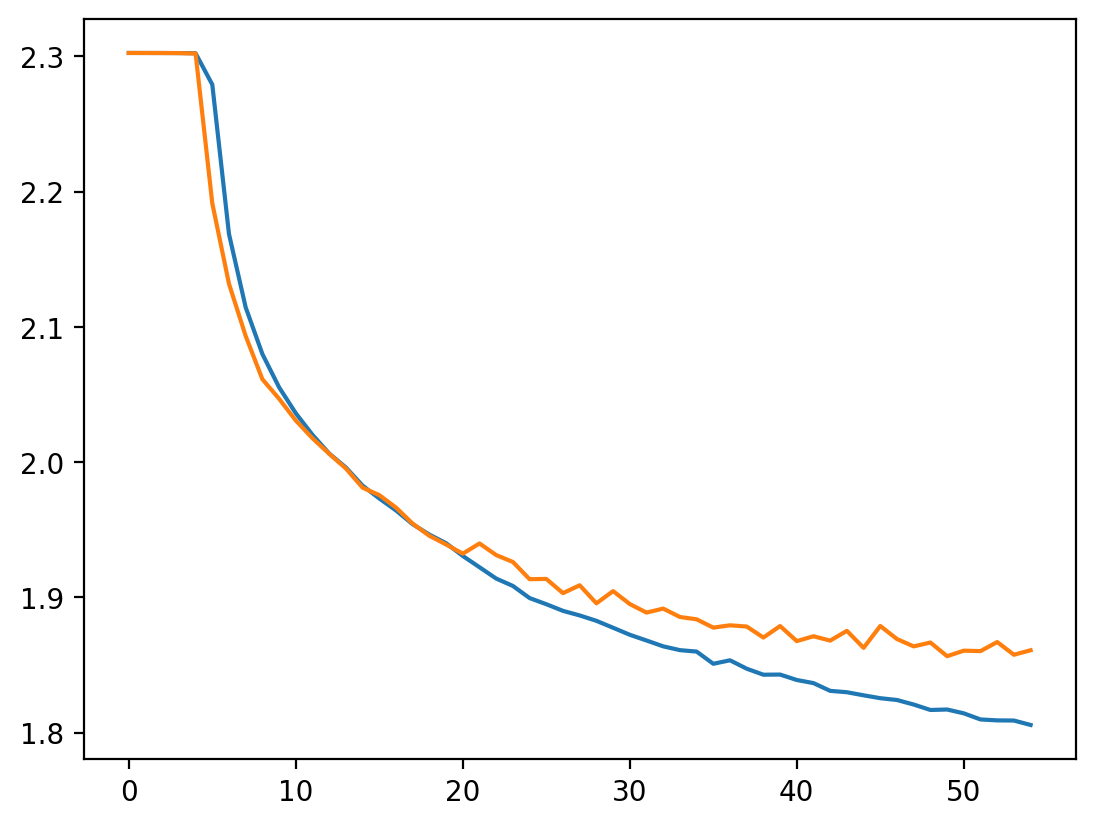

In [ ]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)